# ESS: Introduction to geophysical data analysis with Python
---
This introductory notebook will help you explore frequency domain electromagnetic induction (FDEM) data, and help get you acquainted with basic data operations in Python. It contains code that you can readily use in the Environmental Soil Sensing practicum.<br> 

This [jupyter notebook](https://docs.jupyter.org/en/latest/) is made up of text cells (markdown) like this one, and code cells (with [Python](https://docs.python.org/3/tutorial/) code), such as the two cells below these. Note that in code cells, there also is text (comments), which is preceded by a shebang (`# This is a comment`) or placed between two sets of three parentheses (`'''This is a comment'''`).

In these first cell you will install and import specific packages (ready-made sets of code) that you will use to perform analyses in this notebook. The install script has functionality in Colab, Jupyter as well as in standard IDE's.

If you are unfamiliar with Python code and Jupyter notebooks, you find some introductory notebooks in the [DS-python-geospatial repository](https://github.com/jorisvandenbossche/DS-python-geospatial/tree/main/notebooks), developed by Joris Van den Bossche. However, since you can this notebook with Google Colaboratory, all steps are automated and you should have a smooth experience in using all this! Extensive documentation is provided in these code cells to help you along the way.

---

There is a lot of Python code in this notebook. However, while you are free to modify the code as you want, in cases where you can perform specific operations or data analyses, the part of the code where you can modify variables, or write functions, always appears above a commented line of asterisks, like this: `# ******* `. The part below the asterisk line is where the rest of the code is written that is required to perform the operation, but where to fulfill the practicum you are not required to change anything.

If no asterisk line is present in a code cell, this means you can simply run the code cell without changing anything to get the output.

In [1]:
# Import required packages for setup
# -------------------------------------------- #

import sys
import os

In [2]:
# Set the repository path:
# If the code is run in Google Colab This code will check if the repository is already cloned, if not it will clone it
# If the code is run locally, the repository path is set to the local path
# -------------------------------------------- #

if 'google.colab' in sys.modules:

    repo_path = '/content/I002658A_ESS'
    if not os.path.exists(repo_path):
        !git clone --branch funcbr https://github.com/SENSE-UGent/I002658A_ESS.git
    if repo_path not in sys.path:
        sys.path.append(repo_path)

else:
    sys.path.insert(0, os.path.abspath('PyMEL/src'))
    repo_path = r'/Users/pjdsmedt/repos_mac/I002658A_ESS/' # Change this to the location of the repository on your machine
    if repo_path not in sys.path:
        sys.path.append(repo_path) 

# Import the setup function
from Utils.setup import check_and_install_packages

# Read the requirements.txt file

requirements_path = repo_path + '/Utils/requirements.txt'

with open(requirements_path) as f:
    required_packages = f.read().splitlines()

# Check and install packages
check_and_install_packages(required_packages)

✅ IPython is already installed.
📦 ipywidgets not found. Installing 'ipywidgets'...
🔧 Using subprocess pip install...
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached widgetsnbextension-4.0.13-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata (4.1 kB)
Using cached ipywidgets-8.1.5-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl (214 kB)
Using cached widgetsnbextension-4.0.13-py3-none-any.whl (2.3 MB)
✅ ipywidgets installed and imported successfully.
📦 numpy not found. Installing 'numpy'...
🔧 Using subprocess pip install...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 13.0 MB/s eta 0:00:00a 0:00:01
✅ numpy installed and imported successfully.
📦 pandas not found. Installing 'pandas'...
🔧 Using subprocess pip install...
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━

In [4]:
'''
Import the required modules to run all code in this notebook.
'''

from IPython.display import HTML
from IPython.display import display
from ipywidgets import widgets, HBox

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import clhs
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from sklearn import linear_model
from sklearn.metrics import r2_score

%matplotlib inline

## Set the Working Directory

Do this to simplify subsequent reads and writes (avoid including the full address each time). 

### For use in Google Colab

Run the following cell if you automatically want to get the data from the repository

In [5]:
# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  /Users/pjdsmedt/repos_mac/I002658A_ESS/Notebooks


### For local use

Only run the following cell if you have the data locally stored.

In [10]:
# # set the working directory, place an r in front to address special characters
os.chdir(r'/Users/pjdsmedt/repos_mac/I002658A_ESS/')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  /Users/pjdsmedt/repos_mac/I002658A_ESS


In [11]:
cd

'/Users/pjdsmedt/repos_mac/I002658A_ESS'

# 0. Data exploration
***
First, you will explore the data you are working with. We do this by using the [pandas package](https://pandas.pydata.org/) in Python, which allows you to manipulate and analyse data in a straigthforward way. As you will see, the data you load (.csv-file) are structured in rows and columns that hold the FDEM measurement data. After loading the different datasets you will use in this assignment, you can start evaluating the different datasets that have been collected.

The table below lists all columns of the FDEM datasets, and explains their datatype.

> 
>|Column name|datatype|
>|-----------|--------|
>| *x* | easting [m]|
>| *y* | northing [m]|
>| *z* | elevation [m]|
>| *t* | timestamp [s]|
>| *HCP0.5* | 0.5 m HCP LIN ECa data [mS/m]|
>| *PRP0.6* | 0.6 m PRP LIN ECa data [mS/m]|
>| *HCP1.0* | 1.0 m HCP LIN ECa data [mS/m]|
>| *PRP1.1* | 1.1 m PRP LIN ECa data [mS/m]|
>| *HCP2.0* | 2.0 m HCP LIN ECa data [mS/m]|
>| *PRP2.1* | 2.1 m PRP LIN ECa data [mS/m]|
>| *HCP0.5_inph* | 0.5 m HCP inphase data [ppt]|
>| *PRP0.6_inph* | 0.6 m PRP inphase data [ppt]|
>| *HCP1.0_inph* | 1.0 m HCP inphase data [ppt]|
>| *PRP1.1_inph* | 1.1 m PRP inphase data [ppt]|
>| *HCP2.0_inph* | 2.0 m HCP inphase data [ppt]|
>| *PRP2.1_inph* | 2.1 m PRP inphase data [ppt]|
>
>*The x and y coordinates are presented in meters Belge Lambert 72 (EPSG:31370), and the elevation (z) in meters above sea level (z).* 
>

In [12]:
# Get dataset location
'''
Here you create variables that hold the location of the different datasets you
will use as strings.

FDEM_surveydata: full example survey dataset of the Bottelare testfield
FDEM_transect: extract of the survey dataset along a reference transect. You can
                use this to test analytical procedures, which you can then 
                deploy across the full survey dataset
cLHS_calibration: calibration sample dataset
cLHS_validation: validation sample dataset
'''

FDEM_surveydata = cd + '//Data//Example//FDEM_bott.csv'
FDEM_transect = cd + '//Data//Example//FDEM_transect.csv'
cLHS_calibration = cd + '//Data//Example//cLHS_calibration.csv'
cLHS_validation = cd + '//Data//Example//cLHS_validation.csv'

# print an example dataset location
print('FDEM_surveydata path: ', FDEM_surveydata)

FDEM_surveydata path:  /Users/pjdsmedt/repos_mac/I002658A_ESS//Data//Example//FDEM_bott.csv


Pandas dataframes
-----------------
Data are often presented in spreadsheets, ascii files, or dataframes. In Python, dataframes are defined as two-dimensional data structures (i.e., data arranged in rows and columns) and can be manipulated with the [Pandas](https://pandas.pydata.org/) package.
The FDEM data are available as a comma-separated filed (.csv-file), which you can load into a pandas dataframe in the next cell. 
After loading the data, you can explore the different dataframes directly, either by going through the rows and columns or by looking at its statistics.

In [13]:
# Load dataset - any time when you want to reset your processing, run this cell.
'''
The loaded datasets are .csv-files. These are read and structured with the 
pandas (imported above as pd) package. In this code cell, you load all datasets
into pandas dataframes. If you leave the lines below unchanged, these are:

    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data 
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0)
d_cal = pd.read_csv(cLHS_calibration, sep=',', header=0)
d_val = pd.read_csv(cLHS_validation, sep=',', header=0)

In [14]:
# Explore first 5 rows of the dataframe
'''
You can perform a wide range of operations on pandas dataframes. These are 
performed by calling 'methods', by simply typing these after the dataframe's 
identifier.

In this cell, you call the 'head' method, which returns the first n rows of the
dataframe. Methods can take in arguments depending on their functionality, which
are typed between brackets. The head method takes a number of n rows as 
argument. 

If you call the head method without arguments (like: df.head()), the number of
rows you get to see defaults to n = 5. This gives the same result as df.head(5).
If you want to visualise the first 10 rows, you pass 10 as the argument, like 
this: df.head(10).
'''

df.head()
# ******************************************************************** #

,x,y,z,t,HCP0.5,PRP0.6,HCP1.0,PRP1.1,HCP2.0,PRP2.1,HCP0.5_inph,PRP0.6_inph,HCP1.0_inph,PRP1.1_inph,HCP2.0_inph,PRP2.1_inph
0,107769.766,183243.971,71.323112,39689.08,50.760167,26.074894,82.719542,49.697069,102.540498,77.181693,0.972043,0.627437,1.008348,-0.017689,1.677678,-2.484993
1,107769.520,183244.091,71.320194,39689.16,50.460167,26.074894,84.114218,43.715309,101.140498,74.781693,0.962043,0.627437,1.006713,-0.010438,1.667678,-2.594993
2,107769.292,183244.205,71.253603,39689.25,48.862674,22.045603,84.114218,43.315309,99.240498,72.581693,0.970333,0.628497,1.006713,-0.030438,1.637678,-2.614993
3,107769.033,183244.340,71.243624,39689.33,48.362674,22.045603,82.614218,42.915309,97.340498,70.981693,0.970333,0.628497,1.006713,-0.020438,1.617678,-2.584993
4,107768.903,183244.408,71.243624,39689.38,48.362674,21.745603,81.114218,42.915309,95.540498,69.881693,0.970333,0.628497,1.006713,-0.020438,1.607678,-2.494993


In [15]:
# Explore statistics of the FDEM measurement data
''' 
Here you perform a different set of operations on the dataframe. By using the
'iloc' method, you can select a specific range of columns and/or rows of a
dataframe. 
In the example below, we evaluate all columns except the first five.
We do this based on the indices of the columns. 
In the example, we evaluate all rows (:) for column five (,5) and all columns 
from column five onwards (:). So: [:,5:] 

If you would want to evaluate rows 5 up to 10, of columns 11 up to 16 you would 
write:
    df.iloc[5:10,10:16]
You can check this by uncommenting (removing the #) from the first line 
below this comment block, and commenting the second line of code (adding a #).

The second operation that is performed here, is the describe() method. This 
provides the descriptive statistics of the dataframe. Adding the iloc method 
allows you to select a specific part of the dataframe. Removing the iloc method 
as 'df.describe())' would output the statistics of the entire dataframe.
'''

df.iloc[5:10,10:16].head()
df.iloc[:,5:].describe()
# ******************************************************************** #

,PRP0.6,HCP1.0,PRP1.1,HCP2.0,PRP2.1,HCP0.5_inph,PRP0.6_inph,HCP1.0_inph,PRP1.1_inph,HCP2.0_inph,PRP2.1_inph
count,18909.000000,18909.000000,18909.000000,18909.000000,18909.000000,18909.000000,18909.000000,18909.000000,18909.000000,18908.000000,18906.000000
mean,12.598687,48.054043,25.061276,58.142265,41.431515,0.954502,0.656459,0.954462,0.055933,1.358352,-2.260186
std,5.333754,17.024549,10.285304,21.313548,16.343634,0.007955,0.022894,0.028171,0.044734,0.156007,0.113754
min,4.219919,7.296719,5.790276,28.551880,16.009245,0.834330,0.263299,0.699409,-0.805337,1.069977,-2.991592
25%,7.892139,37.045440,16.897389,42.684928,30.920782,0.950226,0.652991,0.935076,0.046591,1.249540,-2.316606
50%,12.600249,43.719323,24.711478,51.929669,38.089795,0.955273,0.660740,0.946215,0.060972,1.306143,-2.247156
75%,15.711607,55.569376,30.554101,67.810687,48.331223,0.957491,0.666831,0.968305,0.075407,1.412617,-2.188343
max,38.330153,116.305920,68.272448,524.713544,109.431661,1.030094,0.788147,1.157405,0.903059,2.284165,-1.901460


Data visualization
------------------
Here you can plot the data based on its geographical coordinates. For this, you use the module 'pyplot' from the package 'matplotlib' (imported as 'plt').
In the code block below, you have examples of how to plot point datasets as a scatterplot ("plt.scatter")

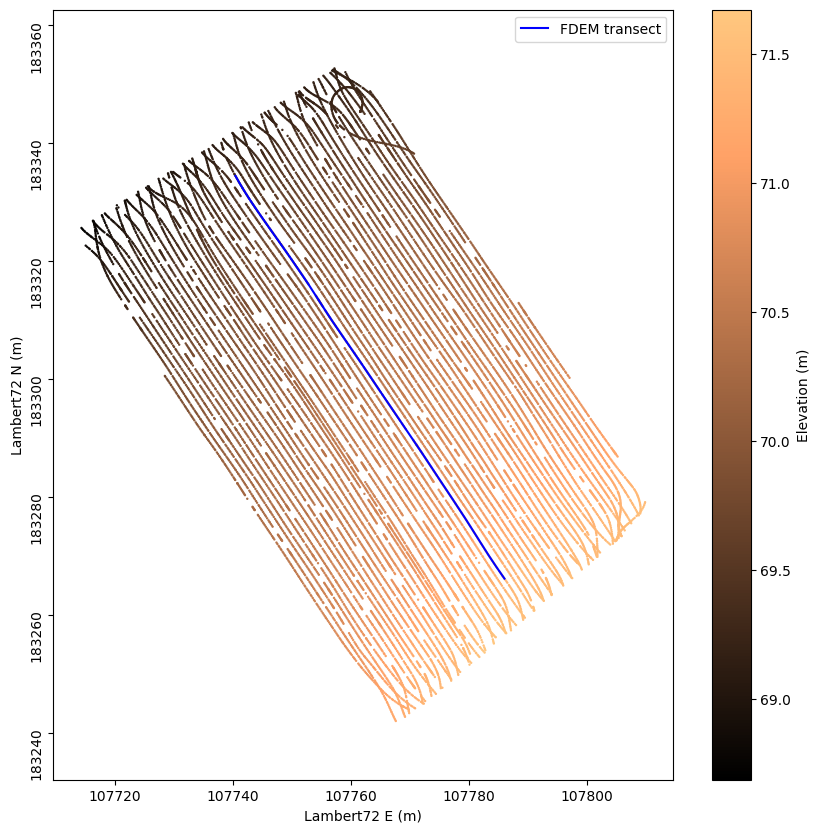

In [16]:
# Visualize GPS coordinates (x,y,z) as a scatterplot. 
'''
General plotting example, plotting the values of the dataframe columns
containing the x & y coordinates, and the elevation as a scatterplot. 
For this, you use the python package Matplotlib (a submodule imported as 'plt').

In this example, you plot the FDEM survey data in the dataframe 'df', and
overlay it with the reference transect in dataframe 'dt'. 
You make explicit that
you want to work with the values of the dataframe by calling .values method of
the dataframe. You can call specific columns by specifying their header as 
df['headername'].
 
'''
plt.figure(figsize=(10, 10))
# plotting the 'df' dataframe as a scatterplot
plt.scatter(df['x'].values,     # x values of the dataframe
            df['y'].values,     # y values of the dataframe
            c=df['z'].values,   # z values, used the colorgrade the scatterplot
                                # markers
            s=.5,               # size of the scatterplot markers
            cmap = 'copper')    # colormap for the scatterplot

# plotting the 'dt' dataframe as a line
plt.plot(dt['x'].values,
        dt['y'].values,
        color = 'blue',
        label = 'FDEM transect')
plt.colorbar().set_label('Elevation (m)')

plt.axis('equal')
plt.xlabel('Lambert72 E (m)')
plt.ylabel('Lambert72 N (m)')
plt.yticks(rotation = 90)
plt.legend()
plt.show()

## Plotting measurement data
In the cell below, you are again plotting the FDEM survey data, only this time, you will plot the output of the data recorded with the various coil configurations. 
By changing the coil geometry type (HCP0.5 - 2.0 or PRP0.6 - 2.1), and the signal component (inphase = False/True), you can visualise the survey measurement data. This will  show you the spatial variation in the data as a first basis for interpretation.<br><br>
You can specify if you want to plot the inphase data or the ECa data by setting the boolean inphase variable to True or False, respectively. 
In the second cell below this text, you can plot the histograms for the IP and QP responses for a given coil geometry.

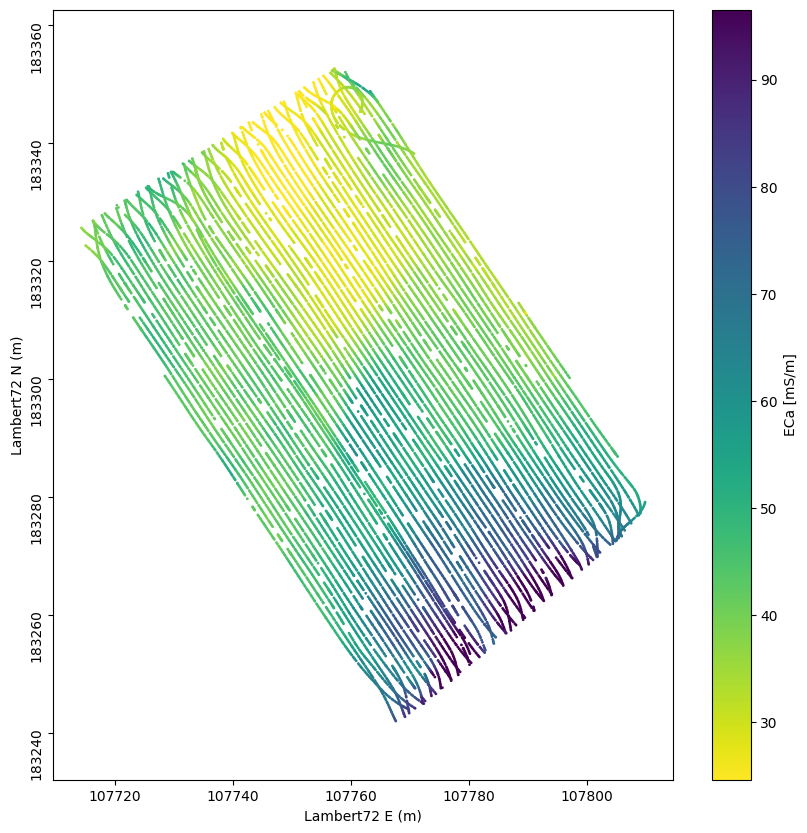

In [17]:
# Coil configuration
cgeometry = 'HCP1.0' # specify coil geometry ('HCP0.5', 'HCP1.0', 'HCP2.0', 
                     # 'PRP0.6', 'PRP1.1', 'PRP2.1')
inphase = False # boolean, False = ECa data; True = inphase data (in ppt)

# ******************************************************************** #

if inphase:
    cc = cgeometry + '_inph'
    label = 'IP [ppt]'
    colorscale = 'Greys'
else:
    cc = cgeometry
    label = 'ECa [mS/m]'
    colorscale = 'viridis_r'

# Colorbar range
cmin_percentile = 2  # %
cmax_percentile = 98  # %
lim0 = np.percentile(df[cc].values, cmin_percentile)
lim1 = np.percentile(df[cc].values, cmax_percentile)

# Visualize the survey itself
plt.figure(figsize=(10, 10))

plt.scatter(df['x'].values, 
            df['y'].values, 
            c=df[cc].values,
            s=1., 
            cmap = colorscale)

plt.colorbar().set_label(label)
plt.clim(lim0, lim1)
plt.gca().set_ylabel(label)
plt.axis('equal')
plt.xlabel('Lambert72 E (m)')
plt.ylabel('Lambert72 N (m)')
plt.yticks(rotation = 90)
plt.show()

In [ ]:
# Run this cell to visualize the histogram of the IP and ECa data 
# from the coil geometry specified in the cell above.

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
cci = cgeometry + '_inph'
plt.hist(df[cci].values, bins=100, log=True)
plt.vlines([np.percentile(df[cci].values, cmin_percentile), 
            np.percentile(df[cci].values, cmax_percentile)], 
           0, 1e5, 
           colors='red')
plt.xlabel(cgeometry + ' IP [ppt]')
plt.ylabel('Counts (-)')

plt.subplot(1, 2, 2)
ccq = cgeometry
plt.hist(df[ccq].values, bins=100, log=True)
plt.vlines([np.percentile(df[ccq].values, cmin_percentile), 
            np.percentile(df[ccq].values, cmax_percentile)], 
           0, 1e5, 
           colors='red')
plt.xlabel(cgeometry +' ECa [mS/m]')
plt.ylabel('Counts (-)')
plt.show()

# 1. Spatial interpolation
---

If we want to move the data space from scattered point observations towards evenly spread observations or raster data we need to make use of a spatial interpolation algorithm.
Examples of these algorithms include nearest neighbor interpolation, linear and cubic interpolation.

You can perform such a simple interpolation in the cells below. For this, you have to define an evenly spaced grid to which the algorithm has to interpolate to.
The interpolation takes the [convex hull](https://en.wikipedia.org/wiki/Convex_hull) as standard boundaries for the interpolation, which makes unwanted extrapolation possible.

In [18]:
'''
Here you perform a simple linear interpolation (alternatively, nearest 
neighbor or cubic interpolation can be performed as well by selecting the 
desired method in the 'griddata' function). 
For interpolating, you simply have to specify the dataset you want to 
interpolate (dataset), and the cell size of the final raster (i.e., the 
resolution of the output grid).
'''

# Input variables
dataset = 'HCP1.0' # column of data values to interpolate
cell_size = 0.5  # raster cell size in meters

# ******************************************************************** #

# Define an evenly spaced grid over which the dataset values have to be 
# interpolated
x_min = df['x'].min()
x_max = df['x'].max()
y_min = df['y'].min()
y_max = df['y'].max()
x_vector = np.arange(x_min, x_max, cell_size)
y_vector = np.arange(y_min, y_max, cell_size)

# Interpolate 
xx, yy = np.meshgrid(x_vector, y_vector)
data_grid = griddata(np.vstack((df['x'].values, df['y'].values)).T, 
                df[dataset].values, 
                (xx, yy), 
                method='linear')  # other methods (nearest, cubic)

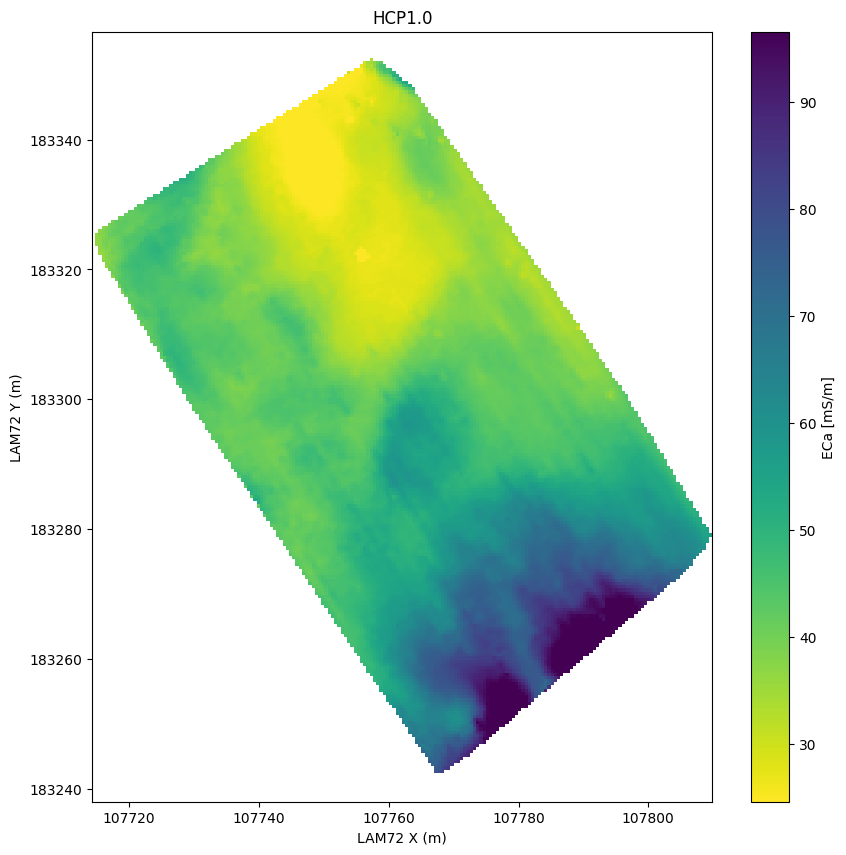

In [19]:
'''
With this code, you can plot your interpolated dataset.
'''

# Check if inphase or ECa data and set parameters accordingly
if 'inph' not in dataset:
        colorscale = 'viridis_r'
        label = 'ECa [mS/m]'
else:        
        colorscale = 'Greys'
        label = 'IP [ppt]'

# Plot interpolated data
plt.figure(figsize=(10, 10))
plt.imshow(
        data_grid, 
        origin='lower', 
        extent=[x_min, x_max, y_min, y_max],
        cmap = colorscale
        )

# set plot range based on dataset value percentiles
plt.clim(
        np.percentile(df[dataset].values, 2), 
        np.percentile(df[dataset].values, 98)
        )
plt.colorbar().set_label(label)
plt.axis('equal')
plt.title(dataset)
plt.xlabel('LAM72 X (m)')
plt.ylabel('LAM72 Y (m)')
plt.show()

# 2. Environmental sampling with ancillary information
---
## Conditioned Latin Hypercube Sampling

[Conditioned Latin Hypercube Sampling](https://doi.org/10.1016/j.cageo.2005.12.009) is a form of latin hypercube sampling that assures selected samples are maximally stratified across the multivariate dataspace, and assures that each sampling point represents a real combination of the multivariate variables. It is an extension of regular latin hypercube sampling, whereby samples are taken across the multivariate distribution. 
The conditioning inherent to cLHS is based on ancillary data, and implies that the hypercube is formed based on the feature space (real multivariate data values). This results in a true or approximate Latin hypercube of the feature space whereby the distribution and multivariate correlation will be preserved.

Details on both traditional LHS and cLHS can be found in [Minasny & McBratney (2005)](https://doi.org/10.1016/j.cageo.2005.12.009).

From the above, the reason for applying cLHS to design a sampling scheme for our study area should be apparent: we have at our disposal an exhaustive, multivariate spatial dataset, which serves as an ideal basis for designing a stratified random sampling approach.

Below you can test different combinations of FDEM datasets for the study area, and design your own sampling scheme using the cLHS algorithm.

In [20]:
# set sample number
number_of_samples = 10

# determine the input variables (x, y-coordinates, and then the measurement data
# you want to include. In the example below this is the PRP1.1 and the HCP2.0 
# ECa data).
sigin = ['x', 'y','PRP1.1', 'HCP2.0'] #

# ******************************************************************** #

# cLHS
sampled = clhs.clhs(df[sigin], number_of_samples, max_iterations=10000)
clhs_sample = df.iloc[sampled['sample_indices']]

'''
Try to plot the resulting sample dataset on top of the interpolated map you
have created. You can base this on the plotting codes provided in the cells
above. You will see that on each run of the cLHS algorithm, a different result
is generated.
'''

cLHS: 18%|█▊        |1803/10000 [Elapsed time: 0.9070210456848145, ETA: 4.051097330436412, 2023.40it/s] /opt/anaconda3/envs/ess_repo/lib/python3.10/site-packages/clhs/clhs.py:760: RuntimeWarning: overflow encountered in exp
  anneal_fac = np.exp(-delta_obj / temp)
cLHS:100%|██████████|10000/10000 [Elapsed time: 5.336897134780884, ETA: 0.0, 1873.75it/s]               


'\nTry to plot the resulting sample dataset on top of the interpolated map you\nhave created. You can base this on the plotting codes provided in the cells\nabove. You will see that on each run of the cLHS algorithm, a different result\nis generated.\n'

## Available sample data

In preparation for this exercise, latin hypercube sampling was already performed using an available FDEM dataset. 
Samples were taken by considering the x, y coordinates, and the ECa data from the PRP 1.1 and HCP 2.0 m coil configurations. <br>
Two sampling datasets were collected. A calibration dataset (`d_cal`), consisting of 10 samples, and a validation dataset (`d_val`), consisting of 5 samples. In both cases, the cLHS algorithm was run separately to generate the sample datasets.
At each sampling location, soil samples were taken at two depth intervals below the surface: at 10-15 cm, and at 50-55 cm depth.

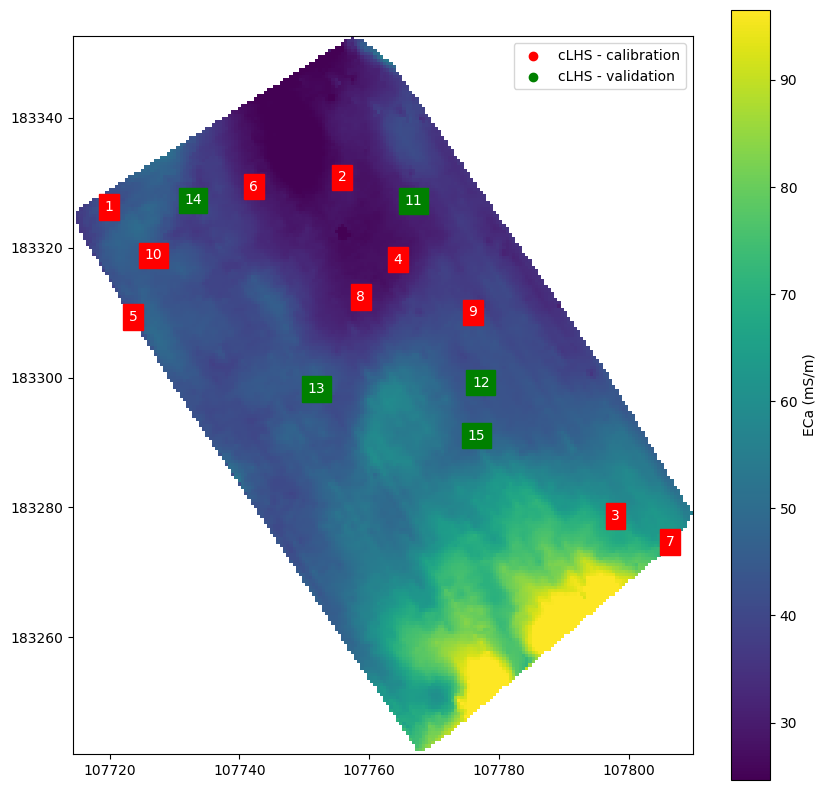

In [21]:
'''
Here you can visualise the sampling locations of the available cLHS dataset
plotted over the dataset you have interpolated above.
'''

# visualing the interpolated dataset
plt.figure(figsize=(10, 10))
plt.imshow(data_grid, origin='lower', extent=[x_min, x_max, y_min, y_max])
plt.colorbar().set_label('ECa (mS/m)')
plt.clim(np.percentile(df[dataset].values, 2), np.percentile(df[dataset].values, 98))

# plotting the 'd_cal' dataframe as points (with their sampling ID)
marker_color = 'red'
font_color = 'white'
plt.scatter(d_cal['x'].values,
        d_cal['y'].values,
        color = marker_color,
        label = 'cLHS - calibration')
for (xi, yi, zi) in zip(d_cal['x'].values, d_cal['y'].values, d_cal['id'].values):
    plt.text(xi, yi, zi, va='center_baseline', 
             ha='center', 
             color = font_color, 
             backgroundcolor = marker_color)

# plotting the 'd_val' dataframe as points (with their sampling ID)
marker_color = 'green'
font_color = 'white'
plt.scatter(d_val['x'].values,
        d_val['y'].values,
        color = marker_color,
        label = 'cLHS - validation')
for (xi, yi, zi) in zip(d_val['x'].values, d_val['y'].values, d_val['id'].values):
    plt.text(xi, yi, zi, 
             va='center_baseline', 
             ha='center', 
             color = font_color,  
             backgroundcolor = marker_color)
plt.legend()


## Data extraction

If you want to extract the data values at the sampling locations, there are two ways to do this. 
First, you can simply query the dataframe that you want to extract the values from (e.g., `df`), to extract the data at the sampled locations (i.e., the x,y-coordinates in `d_cal` or `d_val`). Since samples are taken at coordinates that occur in the survey dataset (`df`), the exact same coordinates are present in the sampling (`d_cal` and `d_val`) and survey (`df`) dataframes.
You can extract the coordinates by performing an inner merge operation as in the first cell below.

Alternatively, you can perform a k-nearest neighbor search using [scipy]('https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html'). This is useful if you are unsure if the coordinates are exactly the same in both datasets. The second code cell perfoms this operation for reference.

These operations are useful to compare different datasets or datatypes, and if you want to perform regressions and predictions based on these data. <br> Below the first two code cells, an example is given on how to perform a [linear regression with Scikit learn](https://scikit-learn.org/stable/modules/linear_model.html), and [polynomial regression using Numpy](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html).

<Figure size 1000x1000 with 0 Axes>

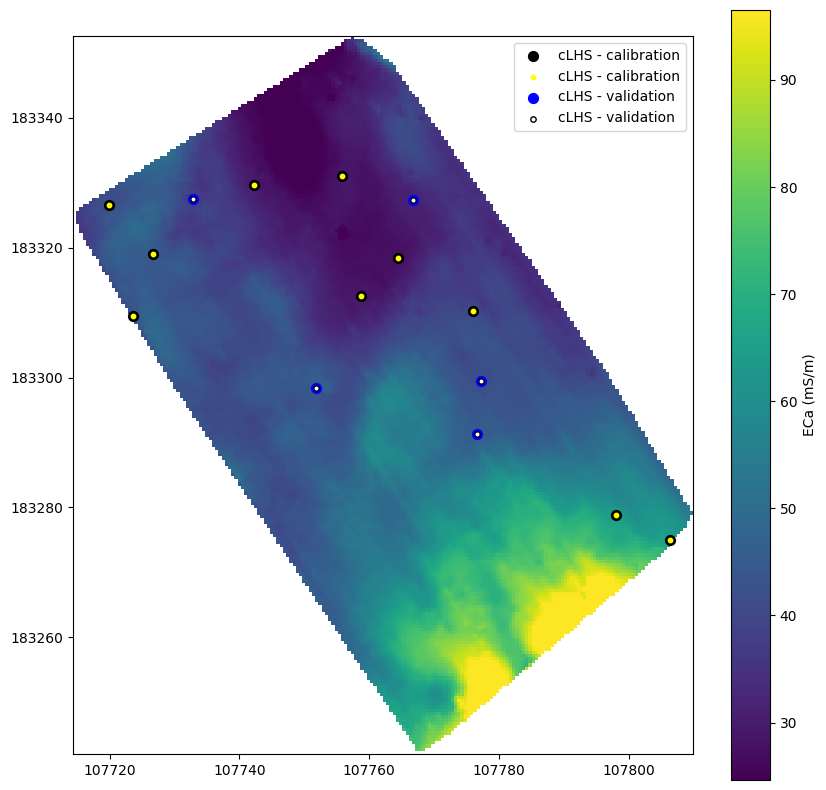

In [22]:
'''
Pandas method: inner merge of dataframes
----------------------------------------
Merge two dataframes and only keep part of the dataframe in which the values 
of specified columns are the same. In this case, you only keep part of the 
dataframe where the x-y coordinates in both evaluated dataframes are exactly 
the same.
'''

calibration_set = pd.merge(df, d_cal, how='inner', on=['x', 'y'])
validation_set = pd.merge(df, d_val, how='inner', on=['x', 'y'])

# plotting the outcomes
plt.figure(figsize=(10, 10))

# visualing the interpolated dataset
plt.figure(figsize=(10, 10))
plt.imshow(data_grid, origin='lower', extent=[x_min, x_max, y_min, y_max])
plt.colorbar().set_label('ECa (mS/m)')
plt.clim(np.percentile(df[dataset].values, 2), np.percentile(df[dataset].values, 98))

plt.scatter(d_cal['x'].values,
        d_cal['y'].values,
        color = 'black', # marker color
        s = 50, # marker size
        label = 'cLHS - calibration')
plt.scatter(calibration_set['x'].values,
        calibration_set['y'].values,
        color = 'yellow',
        s = 10,
        label = 'cLHS - calibration')

plt.scatter(d_val['x'].values,
        d_val['y'].values,
        color = 'blue',
        s = 50,
        label = 'cLHS - validation')
plt.scatter(validation_set['x'].values,
        validation_set['y'].values,
        color = 'white',
        edgecolors = 'black',
        s = 15,
        label = 'cLHS - validation')
plt.legend()
plt.show()

In [23]:
'''
Scipy method - knn search
-------------------------
Perform a knn-search on two dataframes to identify points that are closest
between columns of an input dataframe (in the case below 'df'), and a query
dataframe (in the case below the calibration sample dataset 'd_cal').
'''

# transform dataframes to numpy arrays and perform knn search
data_in = np.array(list(zip(df['x'].values,df['y'].values)) )
data_query = np.array(list(zip(d_cal['x'].values,d_cal['y'].values)) )
btree = cKDTree(data_in)
dist, idx = btree.query(data_query, k=1) # k = number of neighbors; 
                                         # idx = index of the neighbors
                                         # dist = distance between the neighbors       

# Concatenate the survey data values at the location closest to the 
# queried dataset based on the indices 'idx' (df.iloc[idx]), and the queried 
# data themselves.
calibration_set = pd.concat(
    [
    df.iloc[idx],   # part of original dataframe that is closest to queried data                    
    d_cal.set_index(df.iloc[idx].index) # reset index of the queried dataframe
    .rename(columns = {'x':'x_clhs','y':'y_clhs'}) # and rename the x-y columns
    ],
    axis=1 #concatenate along the correct axis (i.e., along the columns)
    )

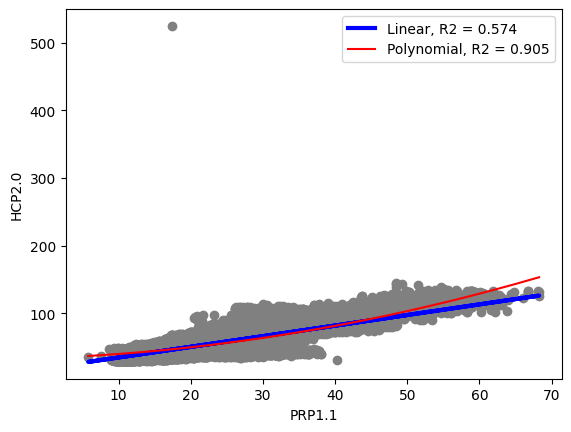

In [24]:
'''
Here it is illustrated how you can perform a linear or polynomial regression
on evaluated datasets. You can create suited models to predict a target 
variable. In the example below, the scikit-learn (sklearn) is used to perform
a linear regression, while numpy (np) is used to do a polynomial regression.

In this example, a regression is made between two of the EMI datasets, which has
no practical sense. In reality, you can use these functions to investigate the 
relationship between sensor data and target properties at sample locations, to
drive stochastic modelling procedures.
'''
# specify which dataframe you want to use (calibration_set, validation_set, df).
#       you can also combine the calibration and validation sets like this:
#       >> dataframe = pd.concat([calibration_set, validation_set])

dataframe = df

# specify the columns of the dataframe you want to use.
column_1 = 'PRP1.1'
column_2 = 'HCP2.0'

# ******************************************************************** #

# assign these to two variables, dataset 1 and 2
dataset_1 = dataframe[column_1].values
dataset_2 = dataframe[column_2].values

'''
to directly use a column of a pandas dataframe in sklearn, we have to make 
explicit the dimensions of the array. You can do this by converting the 
dataframe or dataframe column to a numpy array, or simply by reshaping the 
column you're working with to the correct form as done below.
'''

len_1 = len(dataset_1)
array_1 = dataset_1.reshape(len_1,1)
array_2 = dataset_2.reshape(len_1,1)

# Perform a linear regression with Scikit-learn (sklearn)
lin_reg = linear_model.LinearRegression()
lin_reg.fit(array_1,array_2) # perform a fit on both datasets
lin_pred = lin_reg.predict(array_1)

# Perform a polynomial regression with Numpy (np)
poly_degree = 2
poly_fit = np.poly1d(np.polyfit(dataset_1, dataset_2, poly_degree))
poly_range = np.linspace(
                         np.floor(dataset_1.min()),
                         np.ceil(dataset_1.max()),
                         100
                         )
poly_pred = poly_fit(np.sort(dataset_1)) # get the polynomial regression 
                                         # across the desired range

# Get the coefficient of determination of the performed regressions
#   for this we simply use the sklearn function r2_score

lin_score = r2_score(dataset_2,lin_pred)
ply_score = r2_score(np.sort(dataset_2),poly_pred)

# Plot the results
#   the rounded r-squared values are given in the legend (convert float to 
#   string using >str(); rounding to 3 digits using >np.round()).

plt.scatter(dataset_1, dataset_2,  color='gray')
plt.plot(dataset_1,
            lin_pred, 
            color='blue', 
            linewidth=3, 
            label = 'Linear, R2 = ' + str(np.round(lin_score,3))
            )
plt.plot(np.sort(dataset_1), 
            poly_pred, 
            color = 'red', 
            label = 'Polynomial, R2 = ' + str(np.round(ply_score,3))
            )
plt.xlabel(column_1)
plt.ylabel(column_2)
plt.legend()
plt.show()